In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import os

benchmarks_dir = './benchmarks'
benchmarks = [os.path.join(benchmarks_dir, filepath) for filepath in os.listdir(benchmarks_dir) if filepath.endswith('.csv')]

cuda_benchmarks = [filepath for filepath in benchmarks if not ('results-seq' in filepath)]
seq_benchmarks = [filepath for filepath in benchmarks if 'results-seq' in filepath]

def load_df(filepaths: list[str], label: str):
    df = None
    print(f"Benchmarks ({label}):")
    for filepath in filepaths:
        print(f"- {os.path.relpath(filepath, benchmarks_dir)}")

        df_local = pd.read_csv(filepath)
        if not df:
            df = df_local
        else:
            df = pd.merge(df, df_local)
    return df

In [15]:
df_seq = load_df(seq_benchmarks, 'SEQUENCIAL')
df_seq = df_seq[df_seq['status'] == 'OK']
df_seq = df_seq[['n', 'run', 'result', 'times']]
df_seq = df_seq.groupby(['n']).agg(
    mean=('result', 'mean'),
    median=('result', 'median'),
    max=('result', 'max'),
    min=('result', 'min'),
    std=('result', 'std'),
    count=('run', 'count')
).reset_index()

display(df_seq.head())

Benchmarks (SEQUENCIAL):
- results-seq-n1000-t5-20251128-161321.csv


,n,mean,median,max,min,std,count
0,1000,0.866963,0.863343,0.893874,0.851108,0.015961,5


In [16]:
df_cuda = load_df(cuda_benchmarks, 'CUDA')
df_cuda = df_cuda[df_cuda['status'] == 'OK']
df_cuda = df_cuda[['n', 'bsmode', 'bmulti', 'tfactor', 'run', 'result']]
df_cuda = df_cuda.groupby(['n', 'bsmode', 'bmulti', 'tfactor']).agg(
    mean=('result', 'mean'),
    median=('result', 'median'),
    max=('result', 'max'),
    min=('result', 'min'),
    std=('result', 'std'),
    count=('run', 'count')
).reset_index()

cuda_n_sizes = df_cuda['n'].sort_values().unique().tolist()

display(df_cuda.head())

Benchmarks (CUDA):
- results-n500-t3-20251128-144235.csv


,n,bsmode,bmulti,tfactor,mean,median,max,min,std,count
0,500,device,2,6,0.012383,0.012371,0.012412,0.012367,0.000025,3
1,500,device,2,7,0.010957,0.010959,0.010976,0.010936,0.000020,3
2,500,device,2,8,0.011391,0.011386,0.011413,0.011375,0.000020,3
3,500,device,2,9,0.014010,0.014004,0.014024,0.014002,0.000012,3
4,500,device,2,10,0.014009,0.014012,0.014032,0.013983,0.000025,3


In [17]:
# 2. Agrupar duplicatas (calculando a média de 'avg' e 'std')
for n in cuda_n_sizes:
    grouped = df_cuda[df_cuda['n'] == n]

    # 3. Encontrar as Top 10 Melhores (Menor tempo médio)
    top_10 = grouped.sort_values(by='median', ascending=True).head(10).reset_index(drop=True)
    top_10['rank'] = top_10.index + 1 # Adicionar coluna de Ranking (1 a 10)

    # 4. Exibir a Tabela Formatada
    print(f"=== TOP 10 MELHORES CONFIGURAÇÕES (N={n}) ===")
    display_cols = ['n', 'rank', 'bsmode', 'bmulti', 'tfactor', 'median', 'std', 'count']

    # Estilizar para facilitar a leitura no Notebook
    display(top_10[display_cols].style.background_gradient(subset=['median'], cmap='Greens_r') \
        .format({'median': '{:.6f} s', 'std': '{:.6f}'}))

    print("bmulti:", top_10['bmulti'].sort_values().unique().tolist())
    print("tfactor:", top_10['tfactor'].sort_values().unique().tolist())

=== TOP 10 MELHORES CONFIGURAÇÕES (N=500) ===


,n,rank,bsmode,bmulti,tfactor,median,std,count
0,500,1,host,16,6,0.005611 s,0.000071,3
1,500,2,host,32,6,0.005621 s,0.000108,3
2,500,3,host,8,6,0.005810 s,0.000019,3
3,500,4,host,8,7,0.005959 s,0.000044,3
4,500,5,host,16,7,0.006053 s,0.000034,3
5,500,6,host,32,7,0.006143 s,0.000042,3
6,500,7,host,4,7,0.006415 s,0.000046,3
7,500,8,host,4,6,0.006641 s,0.000029,3
8,500,9,host,4,8,0.007271 s,0.000004,3
9,500,10,host,16,8,0.007317 s,0.000056,3


bmulti: [4, 8, 16, 32]
tfactor: [6, 7, 8]


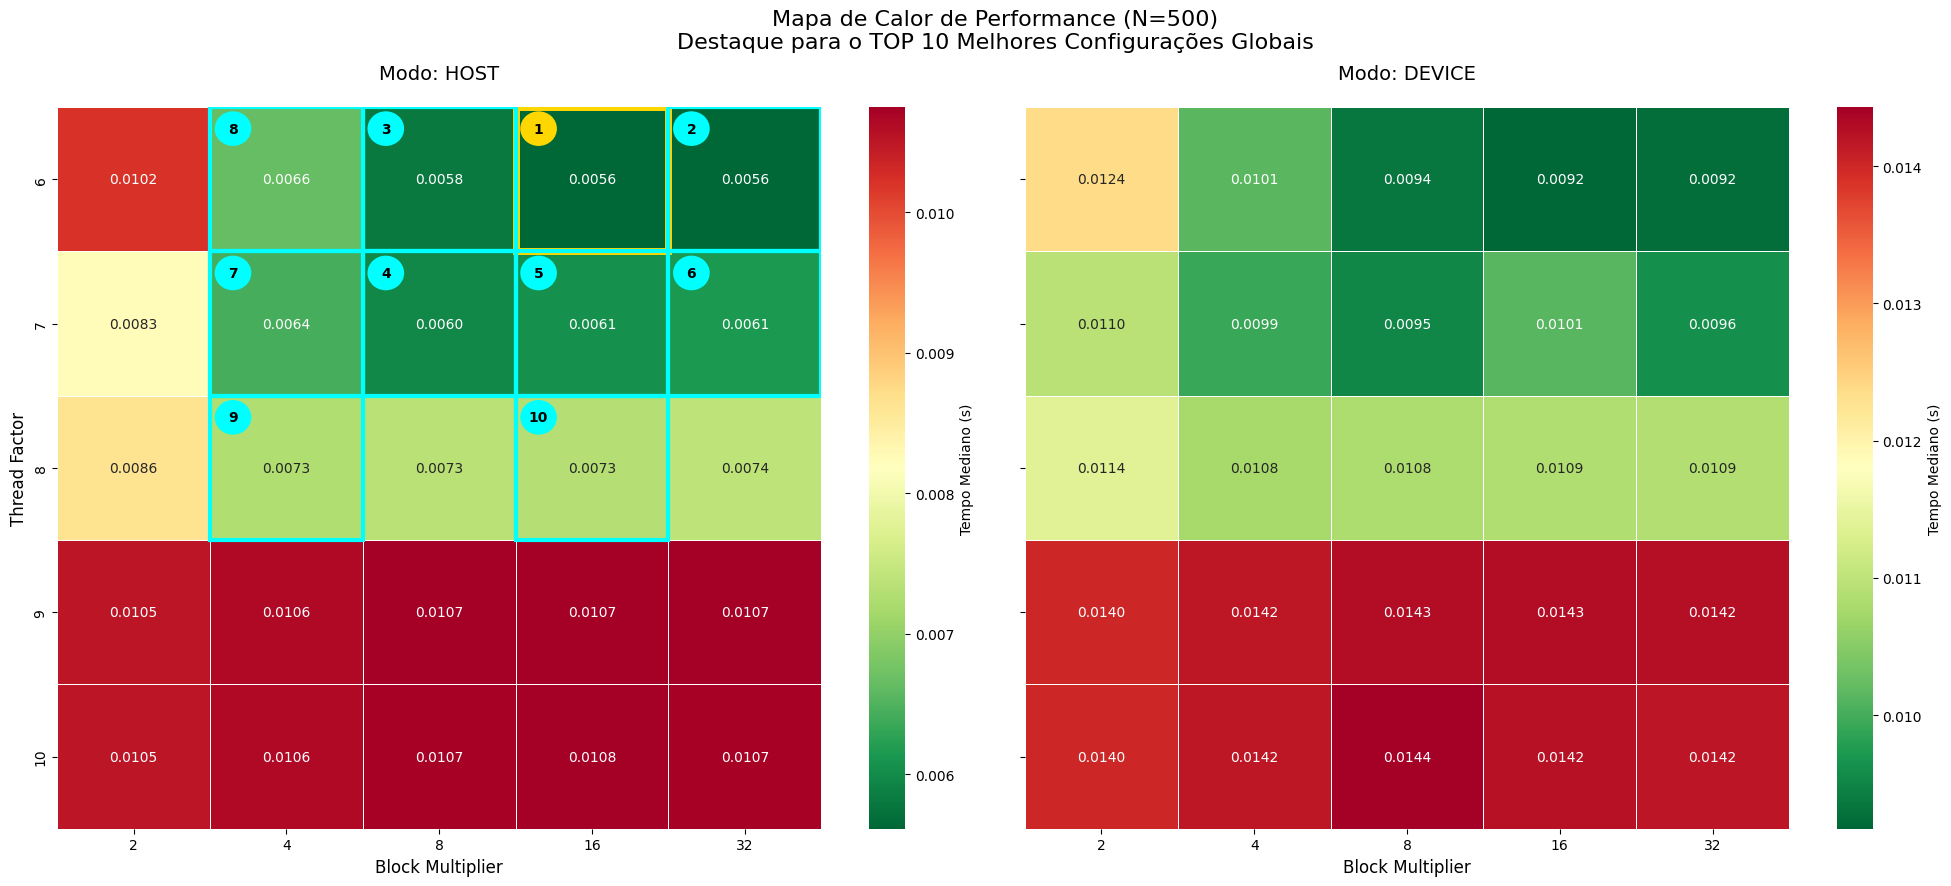

In [18]:
modes = ['host', 'device'] # Ordem dos plots

def show_heatmap(n: int):
    fig, axes = plt.subplots(1, 2, figsize=(20, 9), sharey=True)
    fig.suptitle(f'Mapa de Calor de Performance (N={n})\nDestaque para o TOP 10 Melhores Configurações Globais', fontsize=16)

    grouped = df_cuda[df_cuda['n'] == n]

    for i, mode in enumerate(modes):
        ax = axes[i]
        
        # Filtrar dados apenas para este modo (Host ou Device)
        subset = grouped[grouped['bsmode'] == mode]
        
        # Criar Pivots para o Heatmap
        pivot_median = subset.pivot(index='tfactor', columns='bmulti', values='median')

        if pivot_median.empty:
            continue
        
        # Desenhar o Heatmap base
        sns.heatmap(pivot_median, annot=True, fmt=".4f", cmap='RdYlGn_r', ax=ax, 
                    linewidths=.5, cbar_kws={'label': 'Tempo Mediano (s)'})
        
        ax.set_title(f'Modo: {mode.upper()}', fontsize=14, pad=20)
        ax.set_xlabel('Block Multiplier', fontsize=12)
        ax.set_ylabel('Thread Factor' if i == 0 else '', fontsize=12)

        # --- LÓGICA DE DESTAQUE DO TOP 10 ---
        # Verificar quais dos Top 10 pertencem a este modo (Host ou Device)
        top_in_mode = top_10[top_10['bsmode'] == mode]
        
        for _, row in top_in_mode.iterrows():
            rank = int(row['rank'])
            b_mult = row['bmulti']
            t_fact = row['tfactor']
            
            # Encontrar as coordenadas X, Y no grid do Heatmap
            # O eixo X são as colunas (bmulti)
            # O eixo Y são os índices (tfactor)
            try:
                col_idx = pivot_median.columns.get_loc(b_mult)
                row_idx = pivot_median.index.get_loc(t_fact)
                
                # Definir cor do destaque: Ouro para #1, Azul Ciano para os outros
                edge_color = '#FFD700' if rank == 1 else '#00FFFF'
                line_width = 5 if rank == 1 else 3
                
                # 1. Desenhar o Retângulo
                rect = patches.Rectangle((col_idx, row_idx), 1, 1, 
                                        linewidth=line_width, edgecolor=edge_color, facecolor='none')
                ax.add_patch(rect)
                
                # 2. Adicionar o Número do Rank (badge) no canto
                # Criar um pequeno círculo de fundo para o número ficar legível
                circle = patches.Circle((col_idx + 0.15, row_idx + 0.15), 0.12, 
                                        facecolor=edge_color, edgecolor='none', zorder=10)
                ax.add_patch(circle)
                
                # Texto do número
                ax.text(col_idx + 0.15, row_idx + 0.15, str(rank), 
                        color='black', ha='center', va='center', 
                        fontweight='bold', fontsize=10, zorder=11)
                
            except KeyError:
                # Caso a combinação não esteja no pivot (não deve acontecer se filtrado certo)
                pass

    plt.tight_layout()
    plt.show()

for n in cuda_n_sizes:
    show_heatmap(n)